# Bevy ABM Demographic Analysis

This notebook analyzes the output from the demographic agent-based model.

## 1. Imports

In [7]:
import bevy_abm
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

## 2. Parameter Specification

In [8]:
# Define simulation parameters
params = {
    "initial_population": 50,
    "sim_years": 20.0,
    "export_events": False,  # JSON file output of events

    "death_age": 70.0,
    "min_partner_seeking_age": 20.0,
    "max_partner_seeking_age": 50.0,
    "min_conception_age": 25.0,
    "max_conception_age": 35.0,
    "conception_rate": 0.5,
    "gestation_duration": 0.769,  # ~40 weeks
    "breakup_rate": 0.1,
}

print("Simulation parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

Simulation parameters:
  initial_population: 50
  sim_years: 20.0
  export_events: False
  death_age: 70.0
  min_partner_seeking_age: 20.0
  max_partner_seeking_age: 50.0
  min_conception_age: 25.0
  max_conception_age: 35.0
  conception_rate: 0.5
  gestation_duration: 0.769
  breakup_rate: 0.1


## 3. Run Simulation

In [9]:
# Run the simulation and get results as DataFrames
results = bevy_abm.run_simulation(params)

# Extract individual DataFrames
births_df = results['births']
deaths_df = results['deaths']
partnerships_df = results['partnerships']
breakups_df = results['breakups']
widowings_df = results['widowings']

print("Simulation complete!")
print(f"Total births: {len(births_df)}")
print(f"Total deaths: {len(deaths_df)}")
print(f"Total partnerings: {len(partnerships_df)}")
print(f"Total breakups: {len(breakups_df)}")
print(f"Total widowings: {len(widowings_df)}")

Simulation complete!
Total births: 118
Total deaths: 0
Total partnerings: 59
Total breakups: 39
Total widowings: 0


## 4. Debug: Inspect Births DataFrame

In [10]:
# Show basic info about births DataFrame
print("Births DataFrame shape:", births_df.shape)
print("\nBirths DataFrame schema:")
print(births_df.schema)

print("\nFirst 10 births:")
print(births_df.head(10))

# Separate initial population from births with mothers
initial_population = births_df.filter(pl.col('mother_entity').is_null())
births_with_mothers = births_df.filter(pl.col('mother_entity').is_not_null())

print(f"\nInitial population: {len(initial_population)}")
print(f"Births during simulation: {len(births_with_mothers)}")

Births DataFrame shape: (118, 3)

Births DataFrame schema:
Schema([('child_entity', UInt64), ('mother_entity', UInt64), ('time', Float32)])

First 10 births:
shape: (10, 3)
┌──────────────┬───────────────┬──────┐
│ child_entity ┆ mother_entity ┆ time │
│ ---          ┆ ---           ┆ ---  │
│ u64          ┆ u64           ┆ f32  │
╞══════════════╪═══════════════╪══════╡
│ 4294967296   ┆ null          ┆ 0.0  │
│ 4294967297   ┆ null          ┆ 0.0  │
│ 4294967298   ┆ null          ┆ 0.0  │
│ 4294967299   ┆ null          ┆ 0.0  │
│ 4294967300   ┆ null          ┆ 0.0  │
│ 4294967301   ┆ null          ┆ 0.0  │
│ 4294967302   ┆ null          ┆ 0.0  │
│ 4294967303   ┆ null          ┆ 0.0  │
│ 4294967304   ┆ null          ┆ 0.0  │
│ 4294967305   ┆ null          ┆ 0.0  │
└──────────────┴───────────────┴──────┘

Initial population: 50
Births during simulation: 68


## 5. Analysis: Children per Mother

Calculate and visualize the distribution of number of children per mother.

Children per mother statistics:
shape: (9, 3)
┌────────────┬───────────────┬──────────────┐
│ statistic  ┆ mother_entity ┆ num_children │
│ ---        ┆ ---           ┆ ---          │
│ str        ┆ f64           ┆ f64          │
╞════════════╪═══════════════╪══════════════╡
│ count      ┆ 27.0          ┆ 27.0         │
│ null_count ┆ 0.0           ┆ 0.0          │
│ mean       ┆ 4.2950e9      ┆ 2.518519     │
│ std        ┆ 14.150292     ┆ 1.220667     │
│ min        ┆ 4.2950e9      ┆ 1.0          │
│ 25%        ┆ 4.2950e9      ┆ 2.0          │
│ 50%        ┆ 4.2950e9      ┆ 2.0          │
│ 75%        ┆ 4.2950e9      ┆ 3.0          │
│ max        ┆ 4.2950e9      ┆ 6.0          │
└────────────┴───────────────┴──────────────┘

Top 10 mothers by number of children:
shape: (10, 2)
┌───────────────┬──────────────┐
│ mother_entity ┆ num_children │
│ ---           ┆ ---          │
│ u64           ┆ u32          │
╞═══════════════╪══════════════╡
│ 4294967337    ┆ 6            │
│ 4294967336

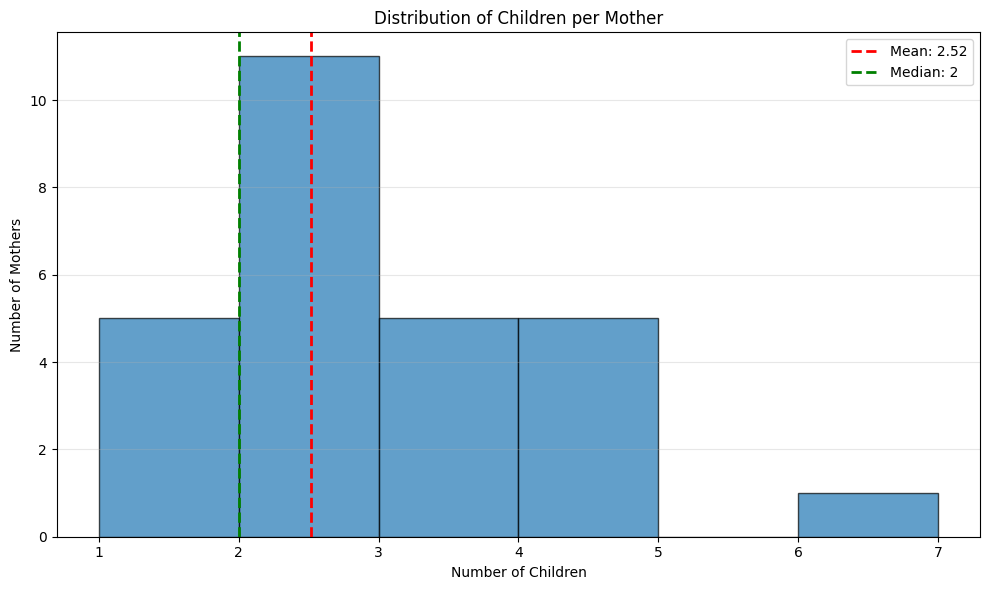


Mean children per mother: 2.52
Median children per mother: 2
Total mothers who gave birth: 27


In [11]:
# Count children per mother (only for births with mothers)
children_per_mother = (
    births_with_mothers
    .group_by('mother_entity')
    .agg(pl.count('child_entity').alias('num_children'))
    .sort('num_children', descending=True)
)

print("Children per mother statistics:")
print(children_per_mother.describe())

print("\nTop 10 mothers by number of children:")
print(children_per_mother.head(10))

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(children_per_mother['num_children'].to_numpy(), bins=range(1, children_per_mother['num_children'].max() + 2), 
         edgecolor='black', alpha=0.7)
plt.xlabel('Number of Children')
plt.ylabel('Number of Mothers')
plt.title('Distribution of Children per Mother')
plt.grid(axis='y', alpha=0.3)

# Add statistics text
mean_children = children_per_mother['num_children'].mean()
median_children = children_per_mother['num_children'].median()
plt.axvline(mean_children, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_children:.2f}')
plt.axvline(median_children, color='green', linestyle='--', linewidth=2, label=f'Median: {median_children:.0f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nMean children per mother: {mean_children:.2f}")
print(f"Median children per mother: {median_children:.0f}")
print(f"Total mothers who gave birth: {len(children_per_mother)}")